In [1]:
from sentiment_analysis import *

In [2]:
reviews = pd.read_csv('./amazon_cells_labelled.txt', sep='\t', header=None)
reviews.columns = ['review', 'score']

In [3]:
'''
This is what the first 5 reviews look like

So there is no way for me to plug it in here in the US unless I go by a converter.	0
Good case, Excellent value.	1
Great for the jawbone.	1
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!	0
The mic is great.	1

'''

'\nThis is what the first 5 reviews look like\n\nSo there is no way for me to plug it in here in the US unless I go by a converter.\t0\nGood case, Excellent value.\t1\nGreat for the jawbone.\t1\nTied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0\nThe mic is great.\t1\n\n'

In [3]:
reviews['exclamation'] = reviews.review.str.contains("!")
reviews["single_quote"] = reviews.review.str.contains("\'")
reviews["allcaps"] = reviews.review.str.isupper()
reviews["num_allcaps_words"] = reviews.review.apply(number_capitalized_words)
# now lets make a copy of this data for the other 4 models
neg_words, pos_words = get_top_words(reviews, 20)

In [4]:
reviews.groupby("score").mean()

,exclamation,single_quote,allcaps,num_allcaps_words
score,,,,
0,0.074,0.194,0.02,0.214
1,0.156,0.124,0.01,0.084


In [5]:
mean_scores = []
for threshold in range(0,15):
    mean_scores.append( reviews.query("num_allcaps_words >= {}".format(threshold)).score.mean() )

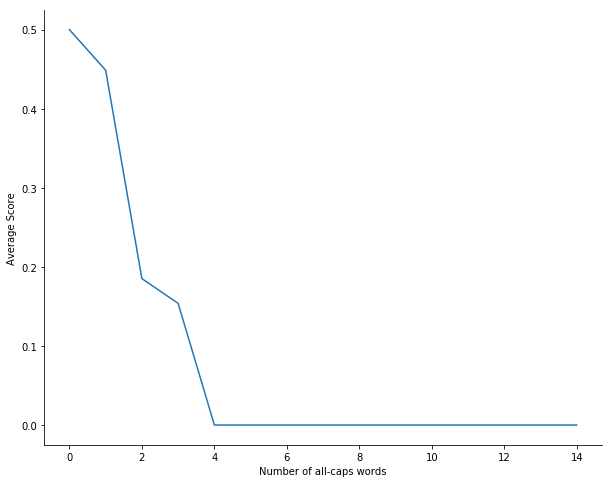

In [6]:
fig = plt.figure(figsize=(10,8))
plt.plot(mean_scores)
sns.despine(fig=fig)
plt.xlabel("Number of all-caps words")
plt.ylabel("Average Score")
plt.show()

In [16]:
# basically what we are looking for here are drastic differences in the means of the 2 groups (score)
reviews.groupby("exclamation").mean()

,score,qingle_quote,allcaps,single_quote
exclamation,,,,
False,0.476836,0.166102,0.012429,0.166102
True,0.678261,0.104348,0.034783,0.104348


**Takeaways**
  * When there is an exclamation mark in the review, the chance it will be negative are 20% higher
  * Basically no difference for all caps - this scenario does not happen often, better to check if the review **contains ONE word in all caps**
  * Do some more comparisons like this.

In [7]:
def analyze_review(review):
    splitter = Splitter()
    postagger = POSTagger()
    splitted_sentences = splitter.split(review)
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)
    
    dicttagger = DictionaryTagger([ 'dicts/positive.yml', 'dicts/negative.yml', 'dicts/inc.yml', 'dicts/dec.yml', 'dicts/inv.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)

    return sentiment_score(dict_tagged_sentences)

In [8]:
reviews["sentiment_score"] = reviews.review.apply(analyze_review)

In [9]:
reviews.head()

,review,score,exclamation,single_quote,allcaps,num_allcaps_words,sentiment_score
0,So there is no way for me to plug it in here i...,0,False,False,False,0,0.0
1,"Good case, Excellent value.",1,False,False,False,0,2.0
2,Great for the jawbone.,1,False,False,False,0,1.0
3,Tied to charger for conversations lasting more...,0,True,False,False,2,0.0
4,The mic is great.,1,False,False,False,0,1.0


In [10]:
reviews.groupby("score").mean()

,exclamation,single_quote,allcaps,num_allcaps_words,sentiment_score
score,,,,,
0,0.074,0.194,0.02,0.214,-0.195
1,0.156,0.124,0.01,0.084,0.877


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


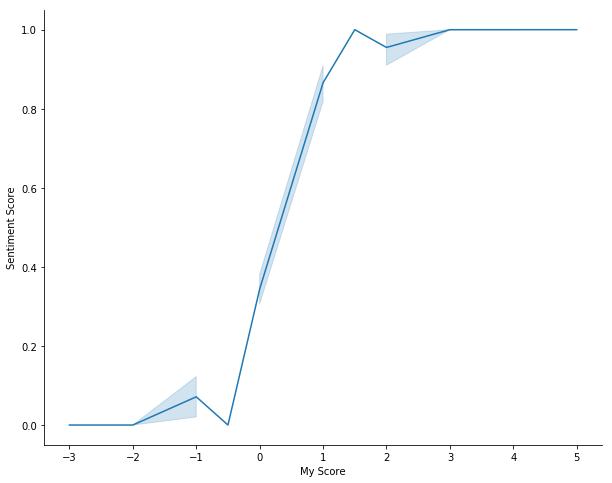

In [9]:
fig = plt.figure(figsize=(10,8))
sns.lineplot(x=reviews.sentiment_score, y=reviews.score)
sns.despine(fig=fig)
plt.xlabel("My Score")
plt.ylabel("Sentiment Score")
plt.show()

  * This is very promising!

/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


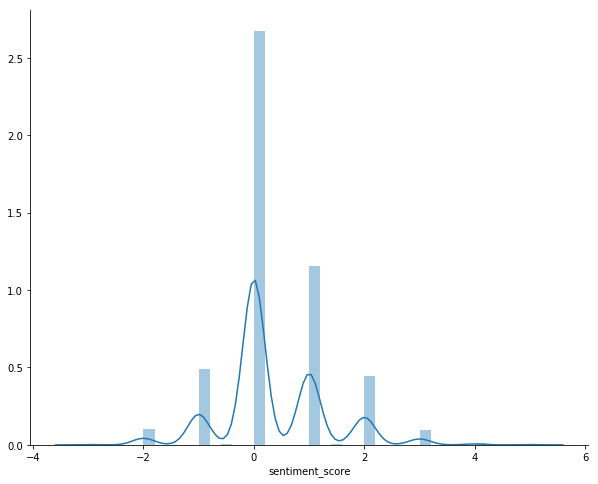

In [38]:
fig = plt.figure(figsize=(10,8))
sns.distplot(reviews.sentiment_score)
sns.despine(fig=fig)
plt.show()

So most are at 0, a few less than 0, whereas a lot more at 1 and same number of reviews scored 2 as scored -1.

In [14]:
# find out the point (my score) where score = 0.5
# looks to be slightly above 0
reviews.groupby("score").mean()

,exclamation,single_quote,allcaps,num_allcaps_words,sentiment_score
score,,,,,
0,0.074,0.194,0.02,0.214,-0.195
1,0.156,0.124,0.01,0.084,0.877


# Models

## Model 1
*positive and negative keywords only*

In [15]:
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )

In [20]:
def build_evaluate_model(reviews, features):
    data = reviews[features]
    target = reviews['score']
    # Instantiate our model and store it in a new variable.
    bnb = BernoulliNB()

    # Fit our model to the data.
    bnb.fit(data, target)

    # Classify, storing the result in a new variable.
    y_pred = bnb.predict(data)

    n = data.shape[0]
    # Display our results.
    print("Number of mislabeled points out of a total {} points : {}".format(
        n,
        (target != y_pred).sum()
    ))

    correct = (n - (target != y_pred).sum())/n * 100
    print("Accuracy: {}%".format(correct))
    
    cv = cross_val_score(bnb, data, target, cv=5)
    print(cv)
    print("cv average is = {:.2f}%".format(cv.mean()*100))
    
    cm = confusion_matrix(target, y_pred)
    print(cm)
    print("True Positive = {:.2f}%".format(cm[1,1]/10))
    print("False Positive = {:.2f}%".format(cm[0,1]/10))
    print("True Negative = {:.2f}%".format(cm[0,0]/10))
    print("False Negative = {:.2f}%".format(cm[1,0]/10))
    print("sensitivity or hit rate is {:.2f}%".format(cm[1,1]/(cm[1,0]+cm[1,1])*100))
    # sensitivity (recall) is the percentage of positives identified or TP/FN+TP
    print("specificity or True Negative rate is {:.2f}%".format(cm[0,0]/(cm[0,0]+cm[0,1])*100))

In [25]:
# First model only uses keywords
build_evaluate_model(reviews, list(pos_words) + list(neg_words))

Number of mislabeled points out of a total 1000 points : 355
Accuracy: 64.5%
[0.655 0.65  0.645 0.655 0.605]
cv average is = 64.20%
[[486  14]
 [341 159]]
True Positive = 15.90%
False Positive = 1.40%
True Negative = 48.60%
False Negative = 34.10%
sensitivity or hit rate is 31.80%
specificity or True Negative rate is 97.20%


## Model 2
*Include exclamation marks as well as number of all-caps words*

In [26]:
build_evaluate_model(reviews, list(pos_words) + list(neg_words) + ["exclamation", "allcaps"])

Number of mislabeled points out of a total 1000 points : 327
Accuracy: 67.30000000000001%
[0.72  0.675 0.66  0.67  0.62 ]
cv average is = 66.90%
[[463  37]
 [290 210]]
True Positive = 21.00%
False Positive = 3.70%
True Negative = 46.30%
False Negative = 29.00%
sensitivity or hit rate is 42.00%
specificity or True Negative rate is 92.60%


## Model 3
*now include the number of all-cap words*

In [29]:
build_evaluate_model(reviews, list(pos_words) + list(neg_words) + ["exclamation", "allcaps", "num_allcaps_words"])

Number of mislabeled points out of a total 1000 points : 329
Accuracy: 67.10000000000001%
[0.72  0.675 0.66  0.67  0.615]
cv average is = 66.80%
[[463  37]
 [292 208]]
True Positive = 20.80%
False Positive = 3.70%
True Negative = 46.30%
False Negative = 29.20%
sensitivity or hit rate is 41.60%
specificity or True Negative rate is 92.60%


In [28]:
reviews.groupby("score").mean()

,exclamation,single_quote,allcaps,num_allcaps_words,sentiment_score,don't,waste,not,worst,money,...,excellent,good.,fine,fine.,great!,data,job,sturdy,far.,phone.
score,,,,,,,,,,,,,,,,,,,,,
0,0.074,0.194,0.02,0.214,-0.195,0.022,0.022,0.168,0.014,0.014,...,0.000,0.000,0.000,0.002,0.0,0.000,0.000,0.000,0.000,0.010
1,0.156,0.124,0.01,0.084,0.877,0.010,0.000,0.024,0.000,0.000,...,0.016,0.002,0.012,0.002,0.0,0.006,0.008,0.008,0.004,0.014


## Model 4

*Now we will just be using the sentiment score we computed and the number of all caps words.*

In [35]:
build_evaluate_model(reviews, ["num_allcaps_words", "sentiment_score"])

Number of mislabeled points out of a total 1000 points : 226
Accuracy: 77.4%
[0.81  0.79  0.765 0.72  0.785]
cv average is = 77.40%
[[465  35]
 [191 309]]
True Positive = 30.90%
False Positive = 3.50%
True Negative = 46.50%
False Negative = 19.10%
sensitivity or hit rate is 61.80%
specificity or True Negative rate is 93.00%


**These numbers are great!**
While accuracy is good, we really want to get the true positive up and the false negative rate down though.

## Model 5

* multinomial version of model 4*

In [36]:
from sklearn.naive_bayes import MultinomialNB

In [65]:
features = ["num_allcaps_words", "sentiment_score"]
data = reviews[features]
# if sentiment_score is negative, assign 0. 
# if positive assign 1
reviews["sentiment_score_scaled"] = data.sentiment_score.map(lambda x: x > 0)

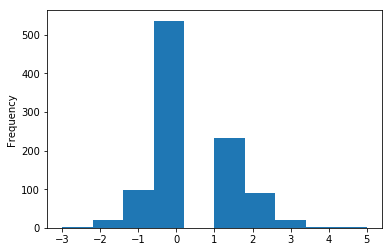

In [45]:
reviews.sentiment_score.plot.hist()

In [67]:
features = ["num_allcaps_words", "sentiment_score_scaled"]
data = reviews[features]
target = reviews['score']


# before we can feed this data to a multinomial model, we must scale the 
# sentiment_score feature to be between 0 and 1

# Instantiate our model and store it in a new variable.
bnb = MultinomialNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

n = data.shape[0]
correct = (n - (target != y_pred).sum())/n * 100

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

print("Accuracy = {:.2f}%".format(correct))

cv = cross_val_score(bnb, data, target, cv=5)
print(cv)
print("cv average is = {:.2f}%".format(cv.mean()*100))

cm = confusion_matrix(target, y_pred)
print(cm)
print("True Positive = {:.2f}%".format(cm[1,1]/10))
print("False Positive = {:.2f}%".format(cm[0,1]/10))
print("True Negative = {:.2f}%".format(cm[0,0]/10))
print("False Negative = {:.2f}%".format(cm[1,0]/10))
print("sensitivity or hit rate is {:.2f}%".format(cm[1,1]/(cm[1,0]+cm[1,1])*100))
# sensitivity (recall) is the percentage of positives identified or TP/FN+TP
print("specificity or True Negative rate is {:.2f}%".format(cm[0,0]/(cm[0,0]+cm[0,1])*100))

Number of mislabeled points out of a total 1000 points : 248
Accuracy = 75.20%
[0.795 0.78  0.73  0.68  0.775]
cv average is = 75.20%
[[467  33]
 [215 285]]
True Positive = 28.50%
False Positive = 3.30%
True Negative = 46.70%
False Negative = 21.50%
sensitivity or hit rate is 57.00%
specificity or True Negative rate is 93.40%


# Conclusions

We observed the best overall accuracy and sensitivity in **Model 4**, but a slightly higher specificity in **Model 5.** Our basic sentiment analysis that we manually performed is the best indicator of review sentiment, and if we further tweak the yaml files (pos/neg/inc/dec/inv.yml) we should be able to improve these rates further.  